**Training Segmentation Models with DeepCell**

Install DeepCell's core library (deepcell-tf)

DeepCell leverages Notebooks to demonstrate model training. This example notebook is a port of optimized for Google Colab. More Example notebooks are available [here](https://github.com/vanvalenlab/deepcell-tf/tree/tf2_migration/notebooks). Most notebooks are structured similarly to this example and thus this notebook serves as a core reference for the DeepCell approach to model training.

In [1]:
# Install the latest version of DeepCell
!pip install -U deepcell

Requirement already up-to-date: deepcell in /usr/local/lib/python3.6/dist-packages (0.8.2)


In [2]:
import deepcell

## Load the data

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.

Here we create a few `Dataset` objects based on existing S3 files. Then we can use the `load_data()` function to load and split the training data. `test_size` is used to adjust the share of data reserved for testing and `seed` is used to generate the random train-test split.

In [3]:
base_url = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
            'demos/janelia/hela_s3_{}_256.npz')

nuclear = deepcell.datasets.Dataset(
    path='nuclear.npz',
    url=base_url.format('nuclear'),
    file_hash='04a200f437aa2f7c66d636c84c379ba7',
    metadata=None
)

fluo_cyto = deepcell.datasets.Dataset(
    path='fluo_cyto.npz',
    url=base_url.format('fluo_cyto'),
    file_hash='6a8a3ba4ddf3de8bb90776fa41a5a664',
    metadata=None
)

phase = deepcell.datasets.Dataset(
    path='phase.npz',
    url=base_url.format('phase'),
    file_hash='c56df51039fe6cae15c818118dfb8ce8',
    metadata=None
)

In [4]:
dataset = phase  # Change this to another dataset! (nuclear, phase, fluo_cyto)

test_size = 0.2 # fraction of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = dataset.load_data(
    test_size=test_size, seed=seed)

print('X_train.shape: {}\nX_test.shape: {}'.format(
    X_train.shape, X_test.shape))

460070912/460063210 [==============================] - 6s 0us/step
X_train.shape: (1872, 256, 256, 1)
X_test.shape: (468, 256, 256, 1)


## Create the PanopticNet Model

Here we instantiate a PanopticNet model from `deepcell.model_zoo` using 3 semantic heads:

* inner distance (1 class)
* outer distance (1 class)
* foreground/background (2 classes)

In [5]:
from deepcell.model_zoo.panopticnet import PanopticNet

semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

## Prepare for training

### Setting up training parameters

There are a number of tunable hyper parameters necessary for training deep learning models:

**backbone**: The majority of DeepCell models support a variety backbone choices specified in the "backbone" parameter. Backbones are provided through `tf.keras.applications` and can be instantiated with weights that are pretrained on ImageNet.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module `tf.keras.optimizers` offers optimizers with a variety of algorithm implementations. DeepCell typically uses the `Adam` or the `SGD` optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.

**min_objects**: Only trains on images with at least this many instances.

In [6]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 5

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 8

min_objects = 2

### Create the DataGenerators

The SemanticDataGenerator can output any number of transformations for each image. These transformations are passed to `generator.flow()` as a list of transform names.

Here we use "inner-distance", "outer-distance" and "fgbg" to correspond to the inner distance, outer distance, and foreground background semantic heads, respectively. Keyword arguments may also be passed to each transform as a dict of transform names to kwargs.

In [7]:
from deepcell import image_generators

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

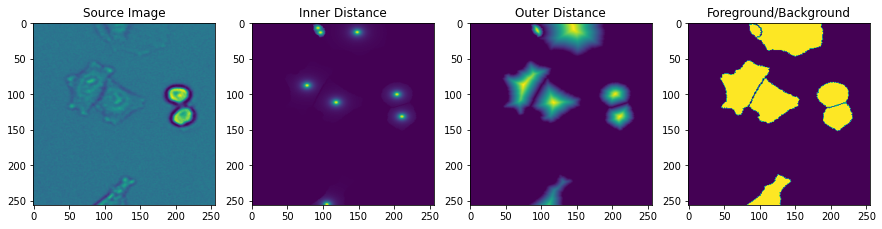

In [8]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 1])
axes[3].set_title('Foreground/Background')

plt.show()

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.


In [9]:
# Create a dictionary of losses for each semantic head
from tensorflow.keras.losses import MSE
from deepcell.losses import weighted_categorical_crossentropy


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [10]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

Call `model.fit()` on the compiled model, with a default set of callbacks.


In [11]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_name = 'phase_deep_watershed'
model_path = '{}.h5'.format(model_name)

print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/5
234/234 [==============================] - ETA: 0s - loss: 0.0502 - semantic_0_loss: 0.0303 - semantic_1_loss: 0.0178 - semantic_2_loss: 0.0022
Epoch 00001: val_loss improved from inf to 0.13887, saving model to phase_deep_watershed.h5
234/234 [==============================] - 111s 473ms/step - loss: 0.0502 - semantic_0_loss: 0.0303 - semantic_1_loss: 0.0178 - semantic_2_loss: 0.0022 - val_loss: 0.1389 - val_semantic_0_loss: 0.0044 - val_semantic_1_loss: 0.0613 - val_semantic_2_loss: 0.0732
Epoch 2/5
234/234 [==============================] - ETA: 0s - loss: 0.0108 - semantic_0_loss: 0.0023 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0011
Epoch 00002: val_loss improved from 0.13887 to 0.09470, saving model to phase_deep_watershed.h5
234/234 [==============================] - 109s 468ms/step - loss: 0.0108 - semantic_0_loss: 0.0023 - semantic_1_loss: 0.0073 - semantic_2_loss: 0.0011 - val_loss: 0.0947 - val_semantic_0_loss: 0.0040 - val_semantic_1_loss:


## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.


In [12]:
from deepcell.model_zoo.panopticnet import PanopticNet

prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape=X_train.shape[1:]
)

In [13]:
prediction_model.load_weights(model_path, by_name=True)

In [14]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = prediction_model.predict(X_test)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape,
      'in', watershed_time, 'seconds.')

Watershed segmentation of shape (468, 256, 256, 1) in 6.8735153899997385 seconds.


419


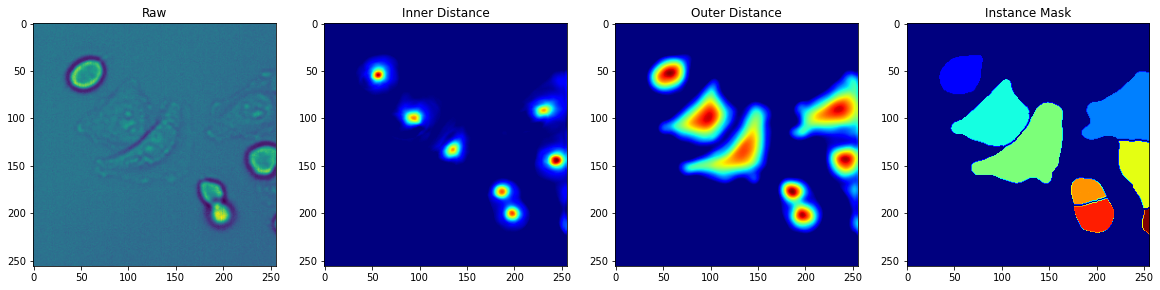

In [15]:
import random

from matplotlib import pyplot as plt

from deepcell_toolbox.deep_watershed import deep_watershed

index = random.randint(0, X_test.shape[0])
print(index)

fig, axes = plt.subplots(1, 4, figsize=(20, 20))

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

# raw image with centroid
axes[0].imshow(X_test[index, ..., 0])
axes[0].set_title('Raw')

axes[1].imshow(inner_distance[index, ..., 0], cmap='jet')
axes[1].set_title('Inner Distance')
axes[2].imshow(outer_distance[index, ..., 0], cmap='jet')
axes[2].set_title('Outer Distance')
axes[3].imshow(masks[index, ...], cmap='jet')
axes[3].set_title('Instance Mask')

plt.show()